In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

In [2]:
def read_df(input_file):
    return pd.read_csv(input_file, index_col='test_number')

In [3]:
def barplot(df, ax, x_key, y_key, secondary_y_key=None, bar_width=0.2, title=None, **kwargs):
    if secondary_y_key is not None:
        ax2 = ax.twinx()
    step = 0
    for compressor in df['compressor_name'].unique().tolist():
        filtered_df = df[df['compressor_name'] == compressor]
        default_title = []
        for key, val in kwargs.items():
            if key == x_key:
                continue
            filtered_df = filtered_df[filtered_df[key] == val]
            default_title.append(f"{key}={val}")
        default_title = ", ".join(default_title)
        mean_df = filtered_df.groupby([x_key]).mean().sort_index()
        x = mean_df.index.to_numpy()
        if x.size == 0:
            continue
        y = mean_df[y_key].to_numpy()
        a = np.arange(len(x))
        yerr = filtered_df.groupby([x_key]).std().sort_index()[y_key].to_numpy()
        ax.bar(a + (step * bar_width), y, bar_width, yerr=yerr, label=compressor)
        ax.set_xticks(a)
        ax.set_xticklabels(x)
        if secondary_y_key is not None:
            t = mean_df[secondary_y_key].to_numpy()
            ax2.plot(a, t)
            ax2.set_xticks(a)
            ax2.set_ylabel(secondary_y_key)
        step += 1
    ax.set_ylabel(y_key)
    ax.grid(axis='y')
    ax.set_xlabel(x_key)
    if title is None:
        ax.set_title(default_title)
    else:
        ax.set_title(title)


def bargrid(df, x_keys, y_keys, secondary_y_key, defaults, rows, cols, figsize, bar_width=0.2, legend=True):
    """grid of barplots. rows * cols should equal |x_keys| * |y_keys|"""
    keys = list(itertools.product(x_keys, y_keys))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, xy_keys in enumerate(keys):
        barplot(
            df=df,
            ax=axes.ravel()[i],
            x_key=xy_keys[0],
            y_key=xy_keys[1],
            secondary_y_key=secondary_y_key,
            bar_width=bar_width,
            **defaults
        )
    if legend:
        handles, labels = axes.ravel()[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
    return fig, axes

In [4]:
# This csv contains metrics for "blosc" and "other-lossless" codecs.
# Input data was 10 random tiles from the exm-hemi-brain.zarr dataset.
# Test machine: ibs-davidf-vm1
# Compressed data written to isilon (/allen/scratch)
# "lossy" codecs (zfpy) not measured in this run.

filepath = r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-10_exm-hemi-brain.zarr.csv"
df = read_df(filepath)

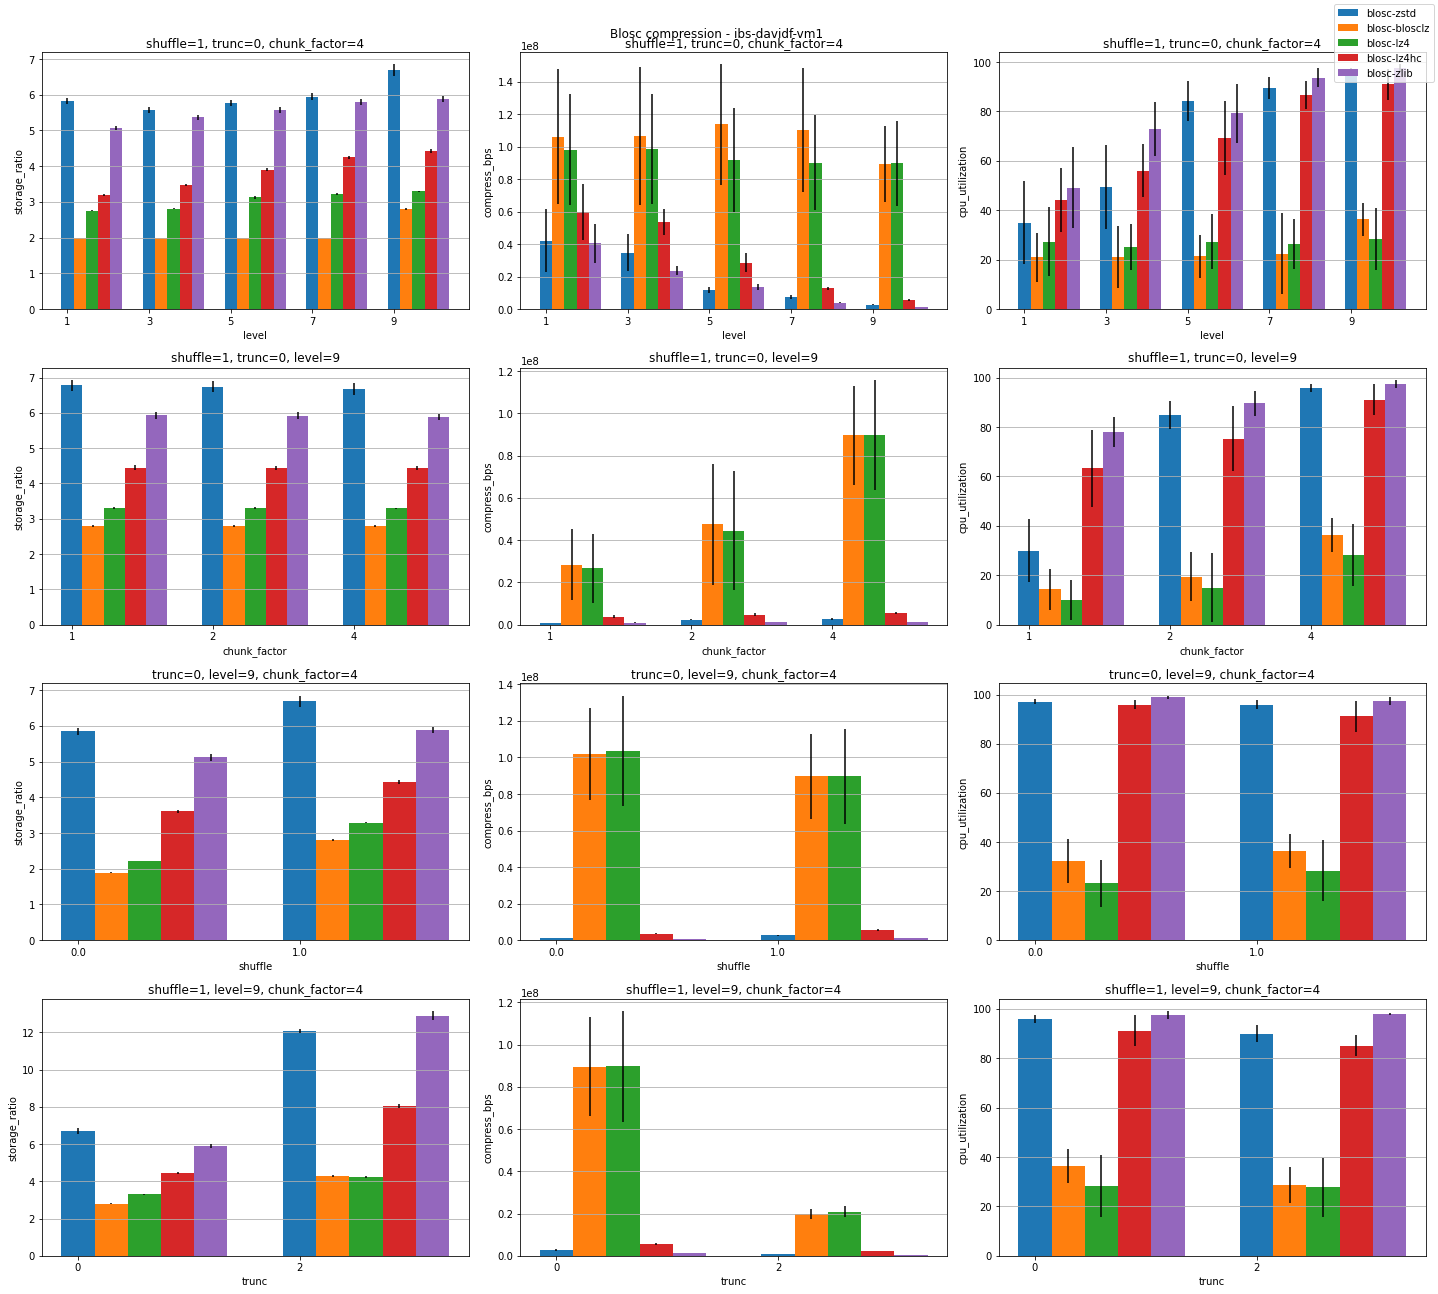

In [5]:
# blosc compression performance

blosc_df = df[df['compressor_name'].str.contains('blosc')]

x_keys = ['level',  'chunk_factor', 'shuffle', 'trunc']
y_keys = ['storage_ratio', 'compress_bps', 'cpu_utilization']
defaults = {
    'shuffle': 1,
    'trunc': 0,
    'level': 9,
    'chunk_factor': 4
}

# number of plots == product of x and y keys
rows = 4
cols = 3
bargrid(blosc_df, x_keys, y_keys, None, defaults, rows, cols, figsize=(20,18), bar_width=0.15)
plt.suptitle(f"Blosc compression - ibs-davidf-vm1")
plt.tight_layout()

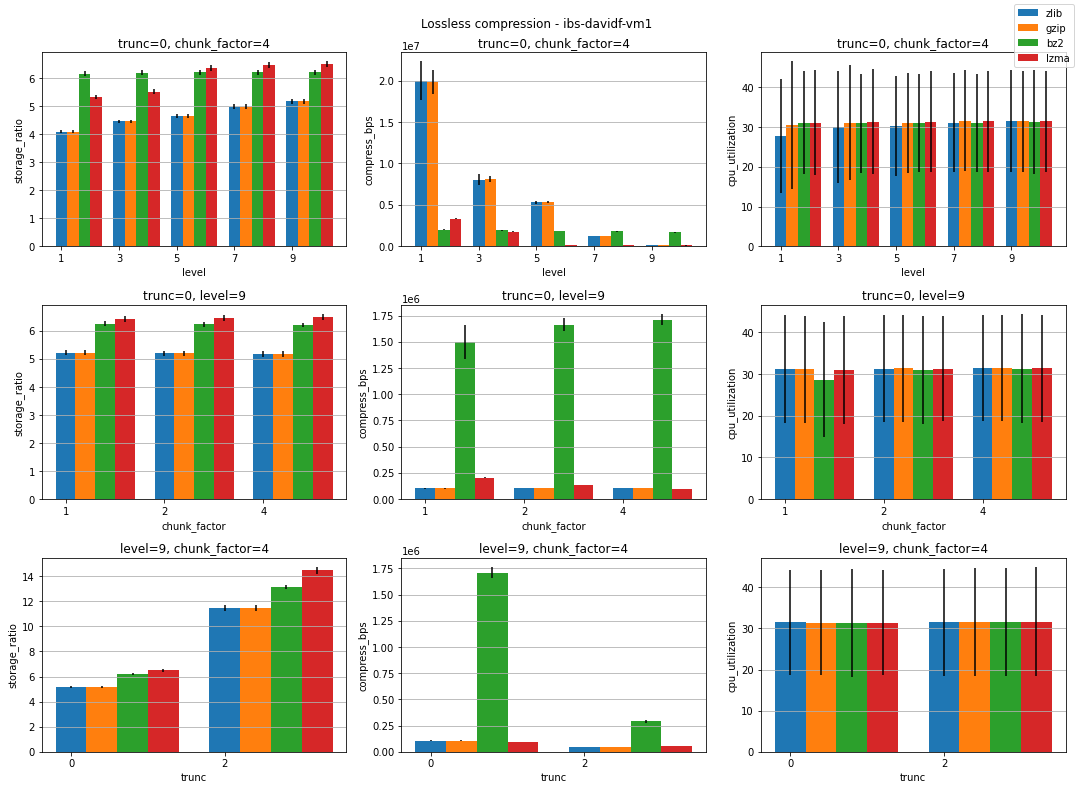

In [6]:
# other lossless codecs

lossless_df = df[~df['compressor_name'].str.contains('blosc')]

x_keys = ['level', 'chunk_factor', 'trunc']
y_keys = ['storage_ratio', 'compress_bps', 'cpu_utilization']
defaults = {
    'trunc': 0,
    'level': 9,
    'chunk_factor': 4
}

rows = 3
cols = 3
bargrid(lossless_df, x_keys, y_keys, None, defaults, rows, cols, figsize=(15,11))
plt.suptitle("Lossless compression - ibs-davidf-vm1")
plt.tight_layout()

In [7]:
def plot_ratios(df, y_labels, title):
    """adapted from http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html"""
    fig, ax = plt.subplots(figsize=(7, df.shape[0] * .25))
    ax.barh(y=np.arange(df.shape[0]), width=df['storage_ratio'].tolist(), height=.8)
    ax.set_yticks(np.arange(df.shape[0]) + .4)
    data = []
    for l in y_labels:
        data.append(df[l])
    ax.set_yticklabels(df[y_labels].apply(tuple, axis=1))
    ax.set_ylabel(", ".join(y_labels))
    ax.grid(axis='x')
    ax.set_xlabel('Storage ratio')
    ax.autoscale(axis='y')
    ax.set_title(title, va='bottom')
    
def plot_speed(df, y_labels, title):
    """adapted from http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html"""
    fig, ax = plt.subplots(figsize=(7, df.shape[0] * .25))
    x = df['compress_bps'] / (2**20)  # MiB/s
    ax.barh(y=np.arange(df.shape[0]), width=x, height=.8)
    # plot data points
    y = np.arange(df.shape[0]) + .4
    ax.plot(x, y, marker='o', linestyle=' ', color='k', markersize=2)
    ax.set_yticks(np.arange(df.shape[0]) + .4)
    ax.set_yticklabels(df[y_labels].apply(tuple, axis=1))
    ax.set_ylabel(", ".join(y_labels))
    ax.grid(axis='x')
    ax.set_xlabel('Speed (MiB/s)')
    ax.autoscale(axis='y', tight=True)
    ax.set_title(title, va='bottom')
    for i, (xi, ri) in enumerate(zip(x, df['storage_ratio'])):
        ax.annotate('%.1fX' % ri, xy=(xi, i + .4), xytext=(5, 0),
                    textcoords='offset points', ha='left', va='center',
                    fontsize=8)

In [8]:
trunc = 0
y_labels = ['compressor_name', 'shuffle', 'level', 'chunk_factor']
blosc_df_trunc = blosc_df[blosc_df['trunc'] == trunc]
# Take the mean over all tiles
blosc_df_trunc = blosc_df_trunc.groupby(y_labels).mean().reset_index()

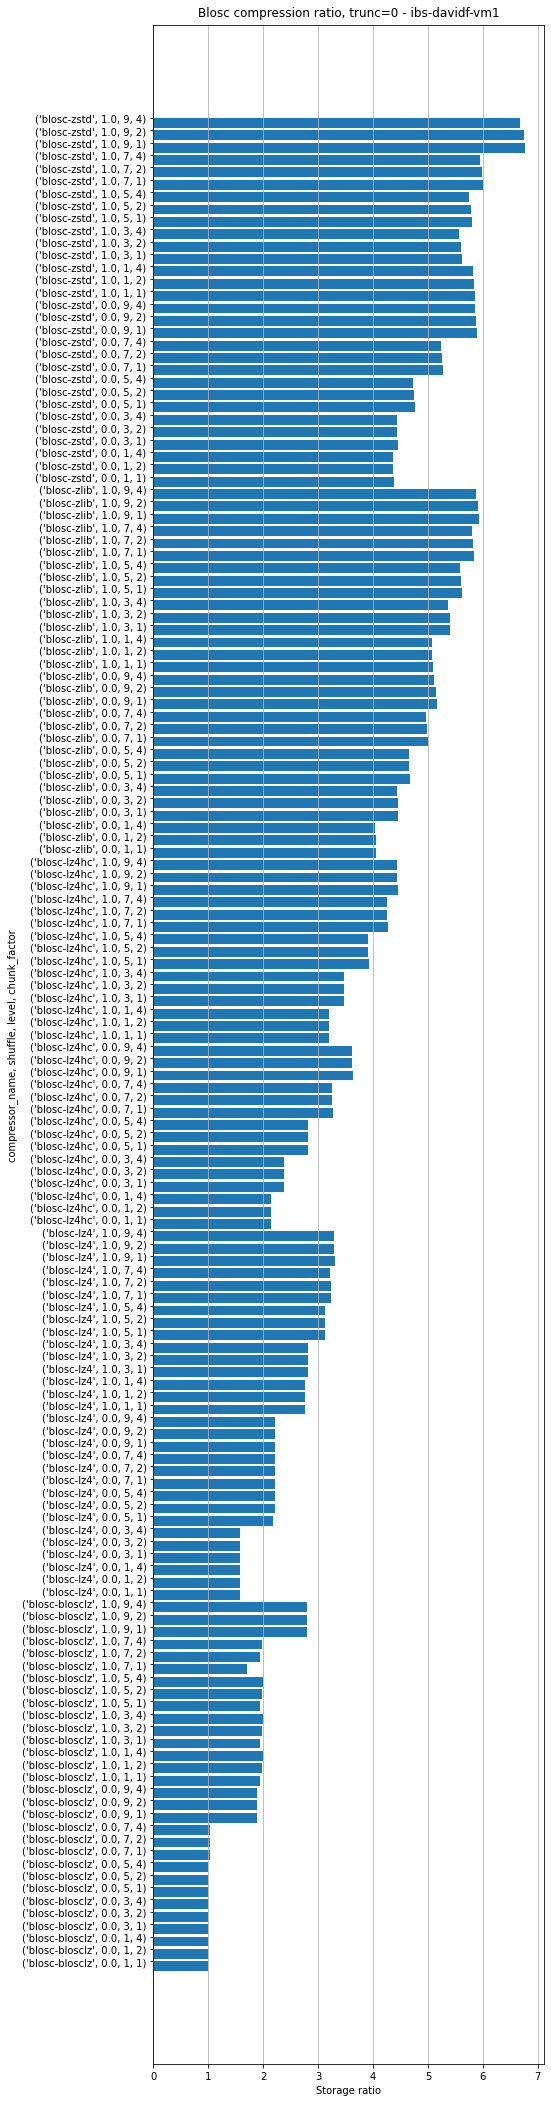

In [9]:
plot_ratios(blosc_df_trunc, y_labels, f"Blosc compression ratio, trunc={trunc} - ibs-davidf-vm1")

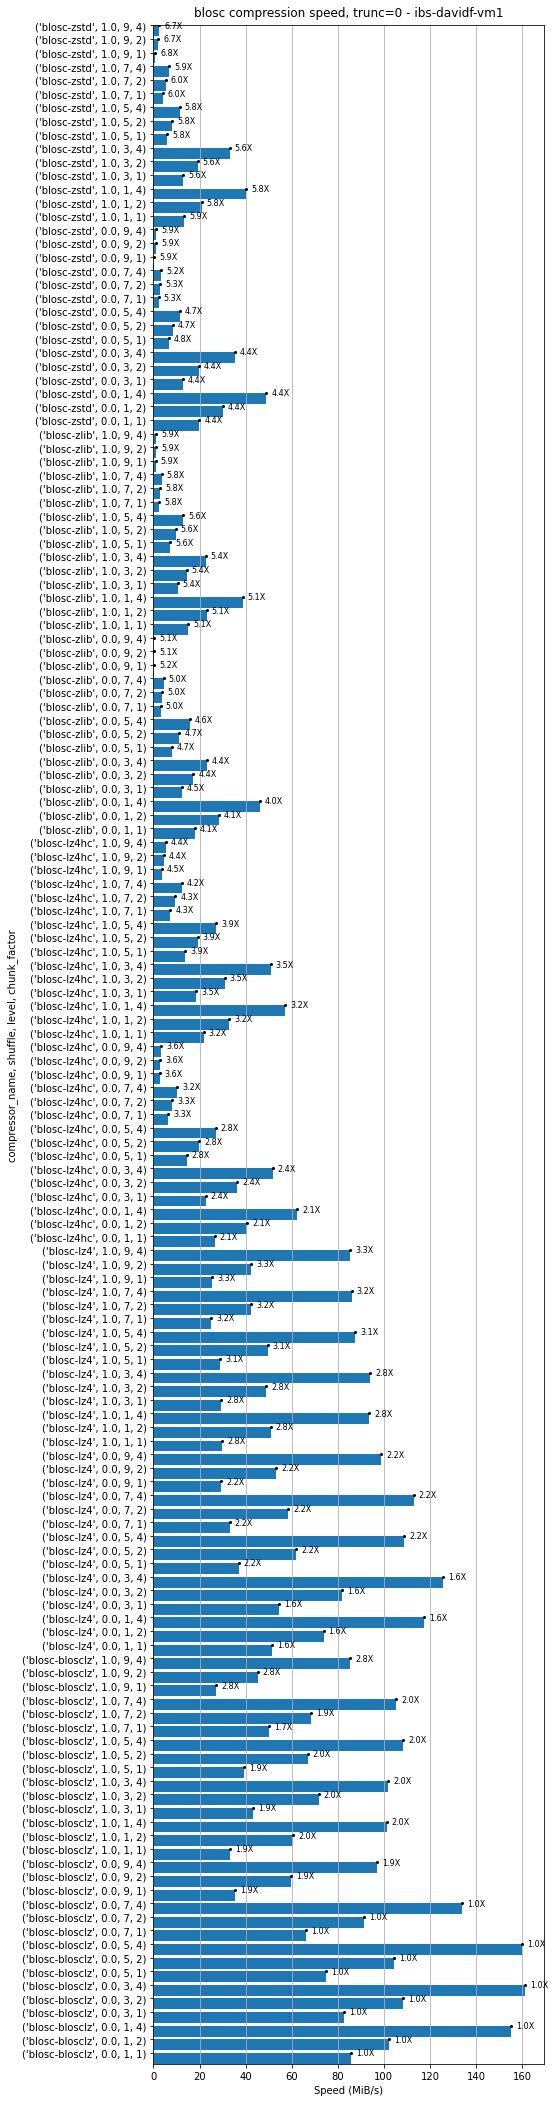

In [10]:
plot_speed(blosc_df_trunc, y_labels, f"blosc compression speed, trunc={trunc} - ibs-davidf-vm1")

In [11]:
trunc = 0
lossless_df_trunc = lossless_df[lossless_df['trunc'] == trunc]
# shuffle is not a key for the lossless compressor library
y_labels = ['compressor_name', 'level', 'chunk_factor']
lossless_df_trunc = lossless_df_trunc.groupby(y_labels).mean().reset_index()

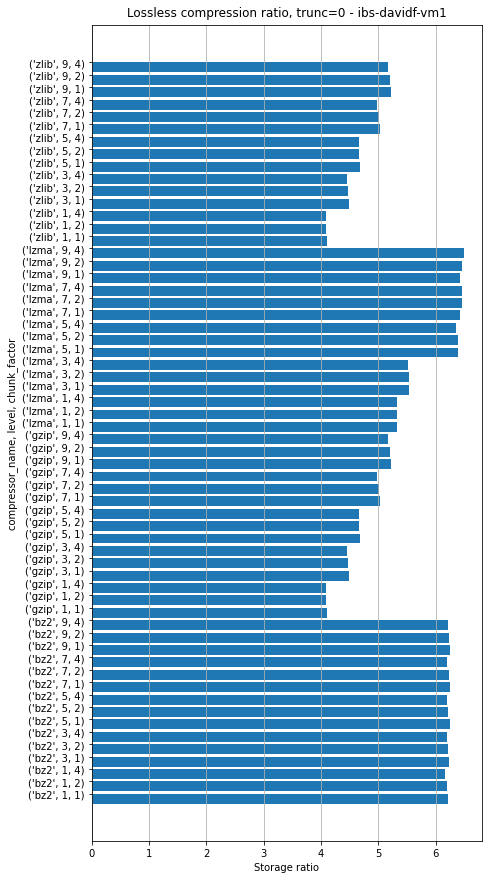

In [12]:
plot_ratios(lossless_df_trunc, y_labels, f"Lossless compression ratio, trunc={trunc} - ibs-davidf-vm1")

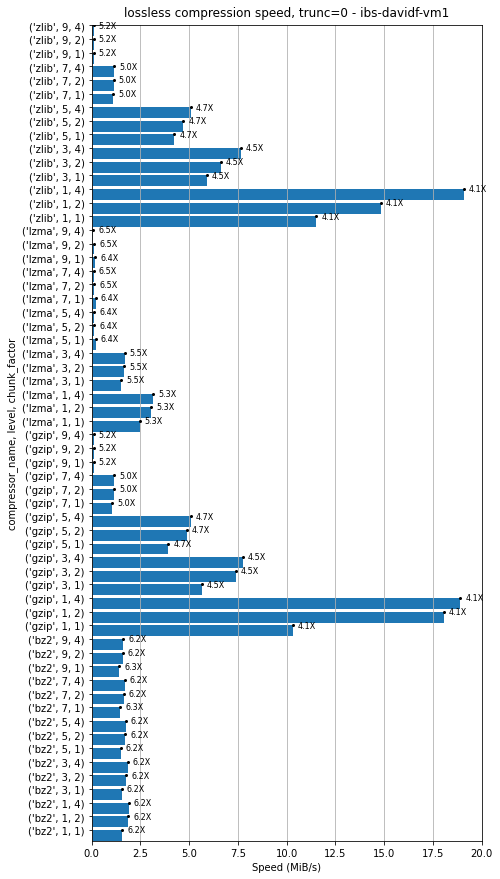

In [13]:
plot_speed(lossless_df_trunc, y_labels, f"lossless compression speed, trunc={trunc} - ibs-davidf-vm1")

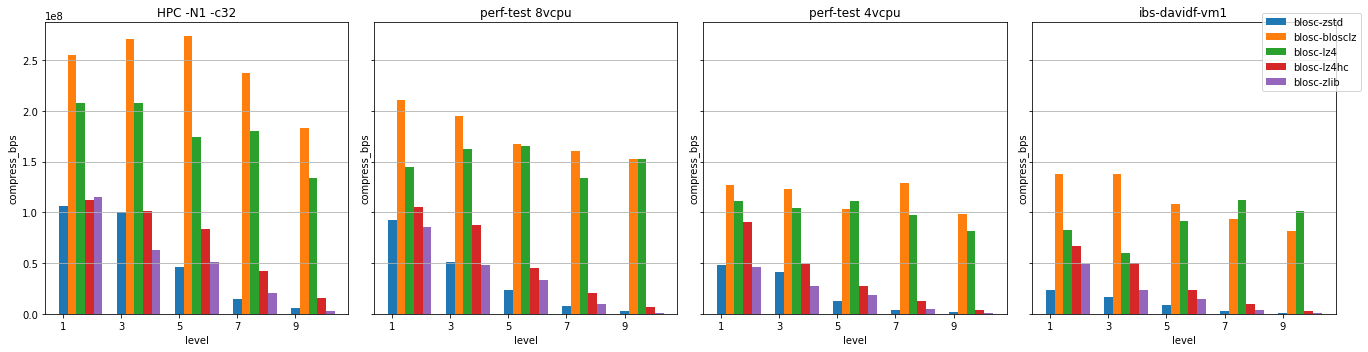

In [14]:
# Comparison of blosc performance on one image tile from the exm-hemi-brain.zarr dataset 
# on different VM configurations and HPC.
# Writing compressed data to isilon (/allen/scratch)

fig, ax = plt.subplots(1,4, sharey=True, figsize=(19,5))

x_key = 'level'
y_key = 'compress_bps'
defaults = {
    'trunc': 0,
    'shuffle': 0,
    'chunk_factor': 4,
    'tile': "s48"
}

barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-16_HPC_32c_16gb_res1_write_b4_exm-hemi-brain.zarr.csv"),
    ax[0],
    x_key,
    y_key,
    title="HPC -N1 -c32",
    bar_width=0.15,
    **defaults
)

barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-14_perf-test_exm-hemi-brain.zarr.csv"),
    ax[1],
    x_key,
    y_key,
    title="perf-test 8vcpu",
    bar_width=0.15,
    **defaults 
)

barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-14_perf-test_4vcpu_8gbram_exm-hemi-brain.zarr.csv"),
    ax[2],
    x_key,
    y_key,
    title="perf-test 4vcpu",
    bar_width=0.15,
    **defaults
)

barplot(
    blosc_df,
    ax[3],
    x_key,
    y_key,
    title="ibs-davidf-vm1",
    bar_width=0.15,
    **defaults
)

ax[3].legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

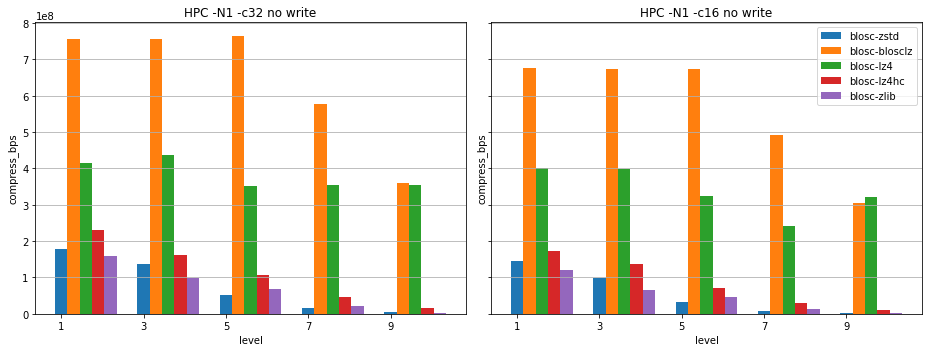

In [15]:
# Test compression speed on one tile from exm-hemi-brain.zarr on HPC with in-memory compression (no data writes)
# Compare 32 core allocation vs 16 core

fig, ax = plt.subplots(1,2, sharey=True, figsize=(13,5))

x_key = 'level'
y_key = 'compress_bps'
defaults = {
    'trunc': 0,
    'shuffle': 0,
    'tile': "s48"
}

barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-16_HPC_32c_16gb_res1_nowrite_b4_exm-hemi-brain.zarr.csv"),
    ax[0], 
    x_key, 
    y_key,
    title="HPC -N1 -c32 no write",
    bar_width=0.15,
    **defaults
)


barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-16_HPC_16c_16gb_res1_nowrite_b4_exm-hemi-brain.zarr.csv"),
    ax[1], 
    x_key, 
    y_key,
    title="HPC -N1 -c16 no write",
    bar_width=0.15,
    **defaults
)

ax[1].legend()
plt.tight_layout()

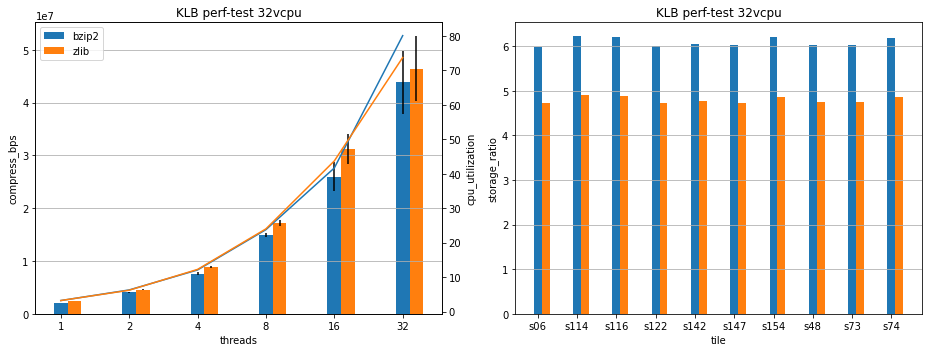

In [16]:
# Keller-Lab-Block (KLB) format tests on 10 random tiles of the exm-hemi-brain.zarr dataset
# Test machine: perf-test 32vcpu
# Compressed data was written to isilon (/allen/scratch)

fig, ax = plt.subplots(1, 2, figsize=(13,5))
barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\klb-compression-metrics-perf-test-32vcpu_exm-hemi-brain.zarr.csv"),
    ax[0], 
    'threads', 
    'compress_bps', 
    secondary_y_key='cpu_utilization', 
    title='KLB perf-test 32vcpu', 
    bar_width=0.2
)
barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\klb-compression-metrics-perf-test-32vcpu_exm-hemi-brain.zarr.csv"),
    ax[1], 
    'tile', 
    'storage_ratio', 
    secondary_y_key=None, 
    title='KLB perf-test 32vcpu', 
    bar_width=0.2
)
ax[0].legend(loc='upper left')
plt.tight_layout()

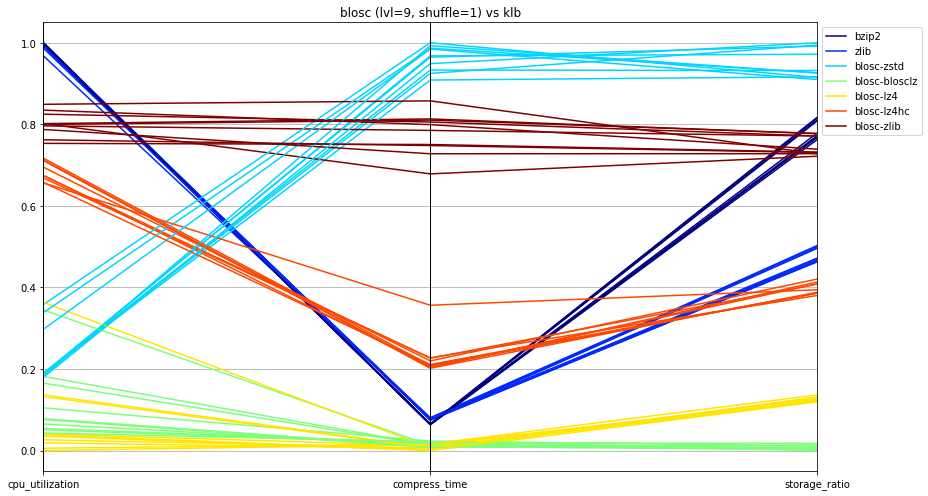

<Figure size 1296x1296 with 0 Axes>

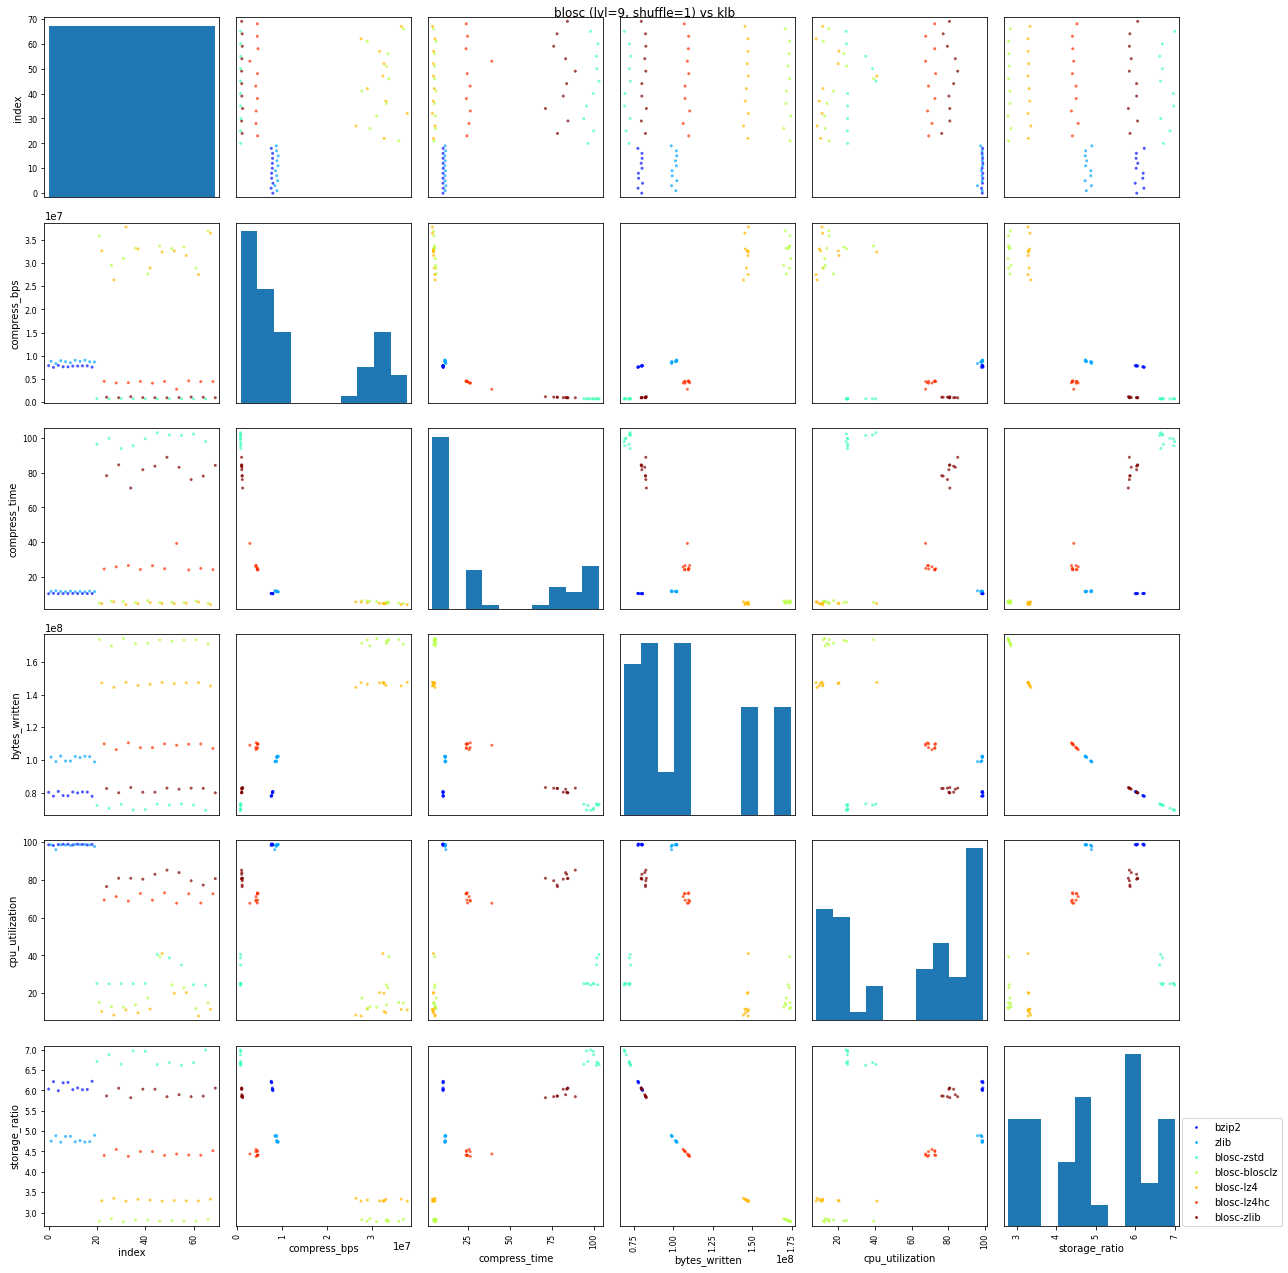

In [17]:
def klb_vs_zarr():
    """Comparison of klb and zarr codec performance on 10 random tiles from the exm-hemi-brain HDF5 dataset.
    Test machine: ibs-davidf-vm1
    Data written to isilon (/allen/scratch)"""
    
    klb_metrics = r"Y:\allen\scratch\aindtemp\cameron.arshadi\klb-compression-metrics_ibs_davidf_vm1_data.h5.csv"
    zarr_metrics = r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_data.h5.csv"

    klb_df = pd.read_csv(klb_metrics, index_col='test_number')
    # Blosc uses up to 8 threads by default
    # Extract relevant observations from klb csv
    klb_df = klb_df[klb_df['threads'] == 4]
    klb_df['format'] = 'klb'

    zarr_df = pd.read_csv(zarr_metrics, index_col='test_number')
    level = 9
    shuffle = 1
    zarr_df = zarr_df[zarr_df['level'] == level]
    zarr_df = zarr_df[zarr_df['shuffle'] == shuffle]
    zarr_df['format'] = 'zarr'

    merged_df = pd.concat([klb_df, zarr_df], ignore_index=True).dropna(axis=1)
    merged_df.reset_index(inplace=True)
    merged_df.drop(['bytes_read', 'read_time', 'read_bps'], axis=1, inplace=True)

    # parallel coordinates
    # standardize features
    from sklearn.preprocessing import MinMaxScaler
    cols = ['cpu_utilization', 'compress_time', 'storage_ratio']
    scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(merged_df[cols]), columns=cols)
    scaled_df['compressor_name'] = merged_df['compressor_name']
    plt.figure(1, figsize=(13, 7))
    pd.plotting.parallel_coordinates(
        scaled_df,
        'compressor_name',
        cols=cols,
        colormap='jet'
    ).legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f"blosc (lvl={level}, shuffle={shuffle}) vs klb")
    plt.tight_layout()

    # pair plot
    plt.figure(2, figsize=(18, 18))
    labels = merged_df['compressor_name'].unique().tolist()
    color_palette = [plt.cm.get_cmap('jet')(i / len(labels)) for i in range(1, len(labels) + 1)]
    color_map = dict(zip(labels, color_palette))
    color_idx = merged_df['compressor_name'].map(lambda x: color_map.get(x))
    pd.plotting.scatter_matrix(merged_df, color=color_idx, figsize=(18, 18), alpha=0.7)
    # hack a legend
    handles = [plt.plot([], [], color=c, ls="", marker=".", markersize=np.sqrt(10))[0] for c in color_palette]
    plt.legend(handles, labels, loc=(1.02, 0))
    plt.suptitle(f"blosc (lvl={level}, shuffle={shuffle}) vs klb")
    plt.tight_layout()

    plt.show()
    
klb_vs_zarr()

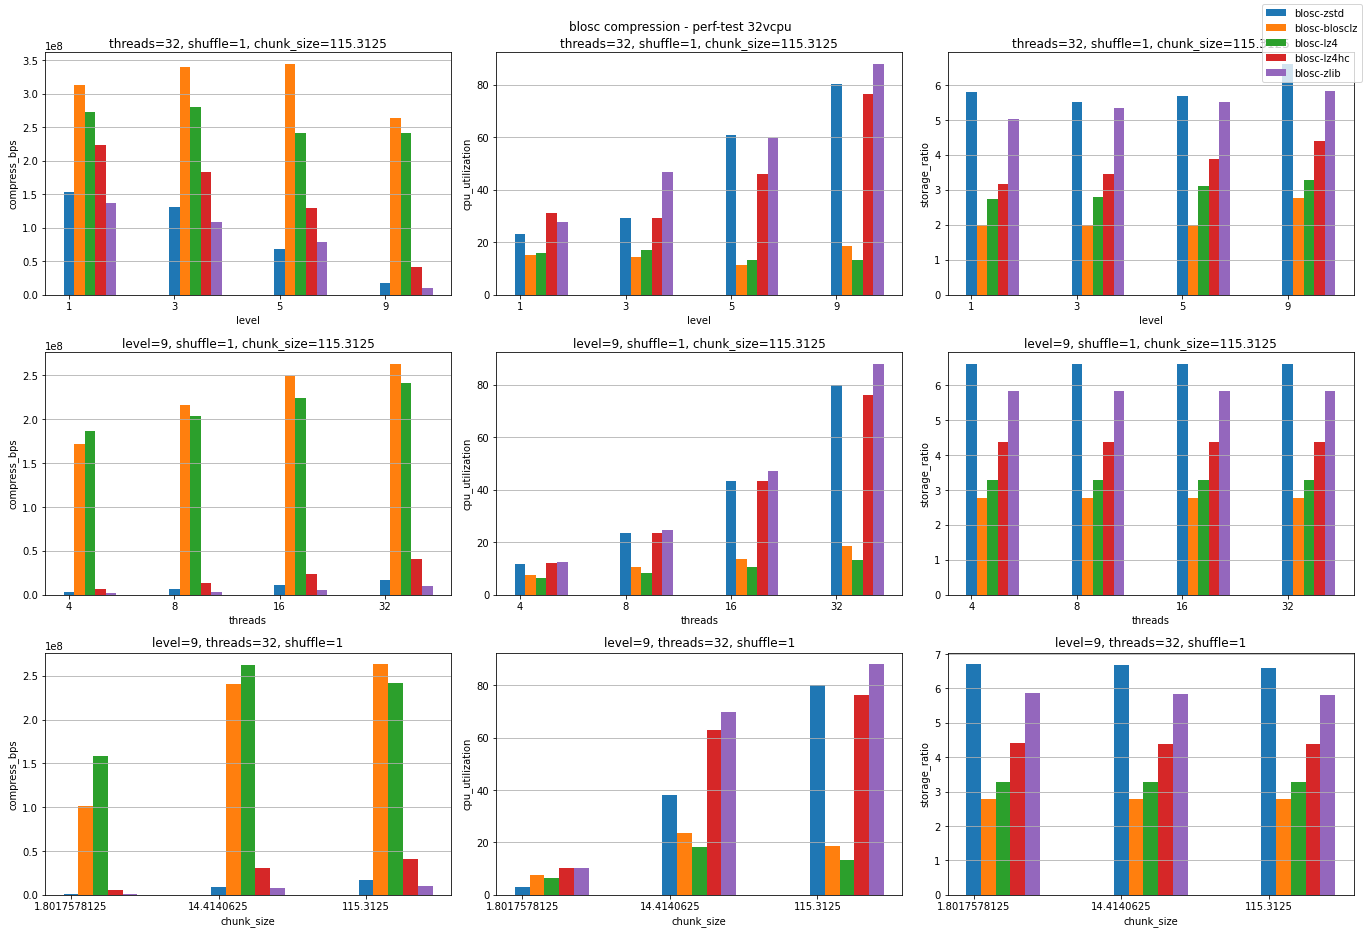

In [18]:
# Blosc compression tests on one tile of exm-hemi-brain.zarr
# Blosc threads are parameterized to assess performance scaling with multiple threads
# Test machine: perf-test 32vcpu
# Compressed data written to /tmp/
# Chunk size in MiB

df = read_df(r"Y:\home\cameron.arshadi\repos\lightsheet-compression-tests\blosc_threads_metrics_exm-hemi-brain.zarr.csv")

x_keys = ['level', 'threads', 'chunk_size']
y_keys = ['compress_bps', 'cpu_utilization', 'storage_ratio']
defaults = {
    'level': 9,
    'threads': 32,
    'shuffle': 1,
    'chunk_size': max(df['chunk_size']),
}
rows = 3
cols = 3
bargrid(df, x_keys, y_keys, None, defaults, rows, cols, figsize=(19,13), bar_width=0.1)
plt.suptitle("blosc compression - perf-test 32vcpu")
plt.tight_layout()

Text(0.5, 0.98, 'JPEG2000 - ibs-davidf-vm1')

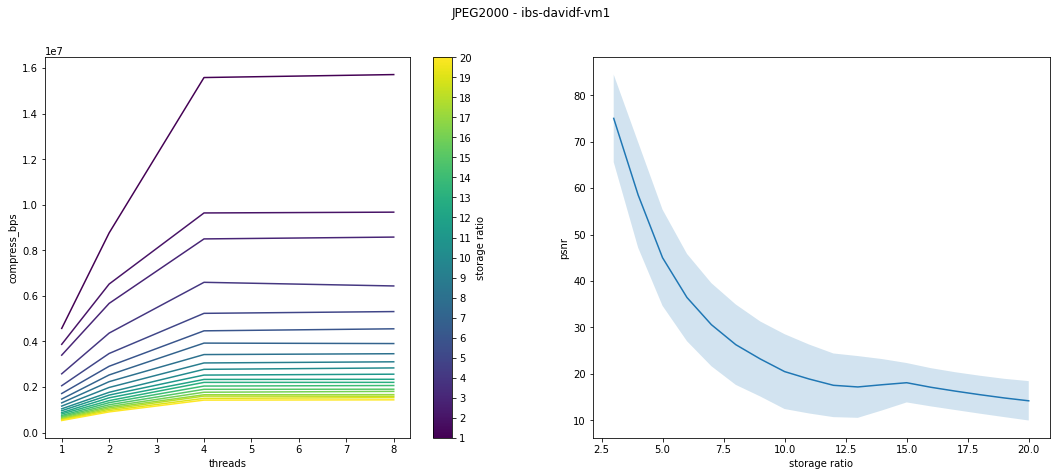

In [19]:
# JPEG2000 via OpenJPEG (glymur) on random single planes of dispim volume BrainSlice1_MMStack_Pos33_15_shift.tif
# Test machine: ibs-davidf-vm1
# Data written to my home directory

jp2_df = read_df(r"Y:\home\cameron.arshadi\repos\lightsheet-compression-tests\jp2-compression-metrics_BrainSlice1_MMStack_Pos33_15_shift.tif.csv")

fig, ax = plt.subplots(1,2, figsize=(18,7))

# compression speed vs threads
gr = jp2_df.groupby('storage_ratio')
colors = plt.cm.viridis(np.linspace(0,1,len(gr)))
for i, (key, g) in enumerate(gr):
    thread_group = g.groupby('threads')
    # take the mean over all tiles
    mean = thread_group.mean().sort_index()
    ax[0].plot(mean.index, mean['compress_bps'], label=key, color=colors[i])
ax[0].set_xlabel('threads')
ax[0].set_ylabel('compress_bps')
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis, 
    norm=plt.Normalize(
        vmin=jp2_df['storage_ratio'].min(), 
        vmax=jp2_df['storage_ratio'].max()
    )
)
cbar = plt.colorbar(sm, ax=ax[0])
cbar.set_ticks(jp2_df['storage_ratio'].unique())
cbar.set_label("storage ratio")

# psnr vs storage ratio
gr = jp2_df[jp2_df['threads'] == 8].groupby('storage_ratio')
xs = gr.groups.keys()
mean = gr.mean()['psnr']
err = gr.std()['psnr']
ax[1].plot(xs, mean)
ax[1].fill_between(xs, mean-err, mean+err, alpha=0.2)
ax[1].set_xlabel("storage ratio")
ax[1].set_ylabel('psnr')
plt.suptitle("JPEG2000 - ibs-davidf-vm1")

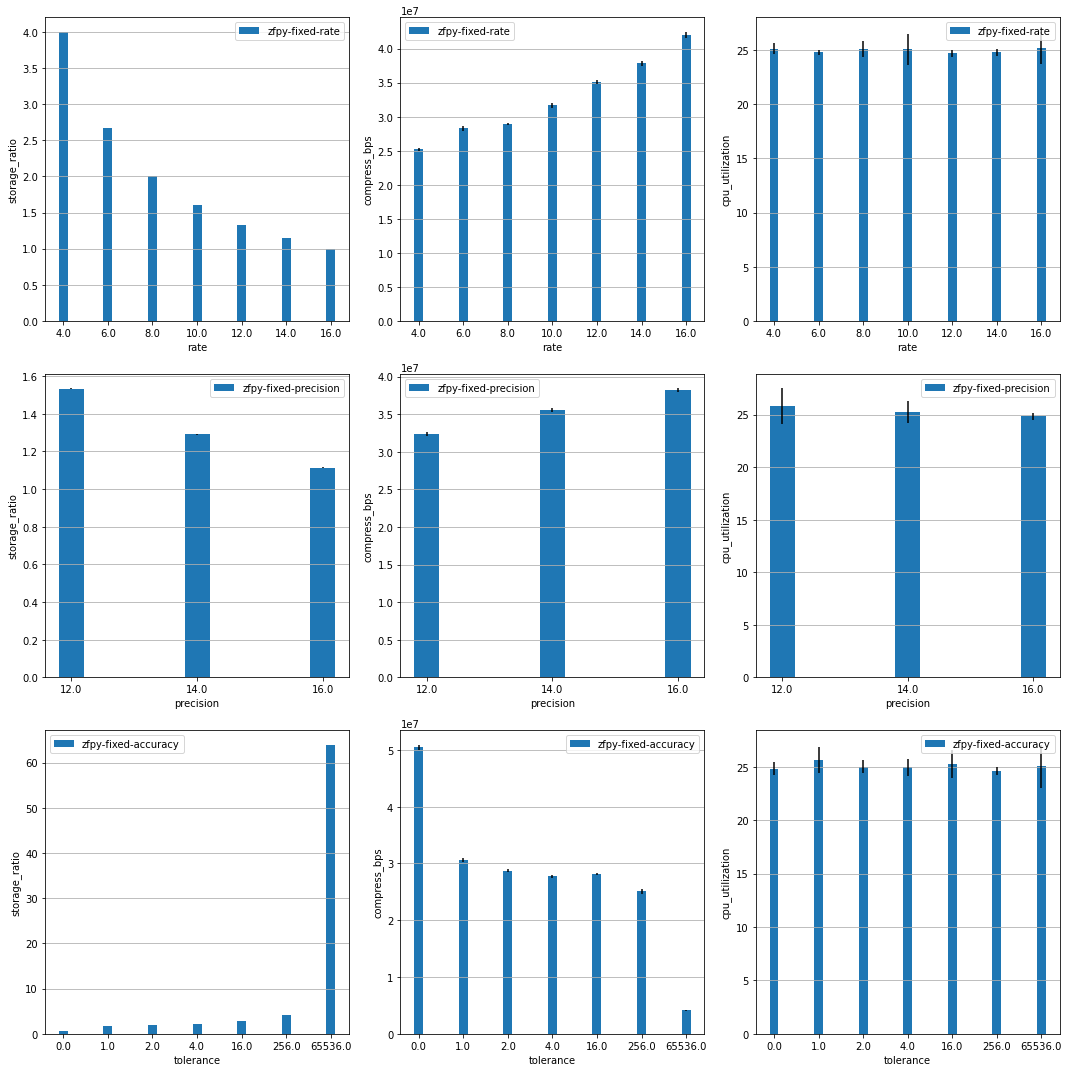

In [20]:
# zfp compression tests on 10 random tiles of exm-hemi-brain.zarr
# Test machine: ibs-davidf-vm1
# Compressed data written to isilon (/allen/scratch)

zfp_df = read_df(r"Y:\home\cameron.arshadi\repos\lightsheet-compression-tests\compression_metrics_zfpy_exm-hemi-brain.zarr.csv")
zfp_df.drop(['trunc', 'level', 'chunk_factor'], axis=1, inplace=True)
x_keys = ['rate', 'precision', 'tolerance']
y_keys = ['storage_ratio', 'compress_bps', 'cpu_utilization']
_, axes = bargrid(zfp_df, x_keys, y_keys, None, defaults={}, rows=3, cols=3, figsize=(15,15), legend=False)
for ax in axes.ravel():
    ax.legend()
plt.tight_layout()